In [ ]:
script_path = "/n/home02/amphillips/p25/scripts" # for cannon
import sys
import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from astropy.table import Table
from scipy.stats import binned_statistic_2d

import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms

from gala.units import galactic

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D


from tqdm import tqdm


sys.path.append(script_path)
# from analyze_petar import analyze_petar
import PETAR_ANALYSIS_FUNCTIONS as paf
import astropy.constants as const
from streamframe import StreamFrame
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
plt.style.use(script_path+'/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from scipy.stats import binom


import io

/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
paths = paf.define_paths()
simcolm_colors, hm_colors, simcolors = paf.define_simcolors()
time_cmap = paf.define_time_cmap()

init_displacements = paf.define_init_displacements()
apocenters = paf.define_apocenters()

dissolution_times, plotting_times_peri, plotting_times_apo = paf.get_tdis_tplot(paths)

In [3]:
dat = np.load ("/n/holystore01/LABS/conroy_lab/Lab/amphillips/finished_grid/IC_info/lowmass.npz") # star data file for generating low-mass ICs
periods = dat['periods'] * u.day
max(np.log10(periods.to(u.year).value))
max_init_period_lowmass = max(periods.to(u.year).value)

In [4]:
# find t_rh0: 
t_rh0 = []
sigv0 = []
t_dyn0 = []
i_list = np.array([0])

npz_path = "/n/holystore01/LABS/conroy_lab/Lab/amphillips/finished_grid/structure_npzs_REAL/"

for n in range(len(paths)):
    rh, nbound, mbound, t_rh, t_dyn, t_dis = paf.compute_cluster_structure( 
        paths[n], i_list, init_displacements[n],
        density_shell_width=0.5 # a .4 pc shell about the half-mass radius is used to compute the density -> crossing time -> relaxation time.
    )
    t_rh0.append(int(t_rh[0]))
    t_dyn0.append(t_dyn[0])

    dat = np.load(npz_path+"%i_structure.npz"%n)
    disp_3d = dat['dispersion_rtid'][0]
    disp_1d = disp_3d/np.sqrt(3)
    sigv0.append(round(disp_1d,2))

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


In [5]:
def load_binary_pairs(path, i):
    """Return a set of unordered binary ID pairs for snapshot i."""
    binaries = petar.Binary(member_particle_type=petar.Particle,
                            G=petar.G_MSUN_PC_MYR,
                            interrupt_mode='bse',
                            external_mode='galpy')
    binaries.loadtxt(path + f"data.{i}.binary")
    return {tuple(sorted((b.p1.id, b.p2.id))) for b in binaries}

def find_disruption_times(path, i_list):
    """
    For binaries present at the FIRST snapshot i_list[0],
    return the disruption time for each, aligned to the
    ordering in that initial snapshot's binary file.
    """
    i0 = i_list[0]

    # ---- load binaries at first timestep
    binaries0 = petar.Binary(member_particle_type=petar.Particle,
                             G=petar.G_MSUN_PC_MYR,
                             interrupt_mode='bse',
                             external_mode='galpy')
    binaries0.loadtxt(path + f"data.{i0}.binary")

    # preserve ordering from the t0 file
    initial_pairs = [tuple(sorted((b.p1.id, b.p2.id))) for b in binaries0]
    
    # initialize disruption times to max(i_list)
    # (meaning “survives until end”)
    disruption_times = {pair: max(i_list) for pair in initial_pairs}

    # track presence
    present_until = {pair: i0 for pair in initial_pairs}

    # ---- loop through later times
    for i in tqdm(i_list[1:]):
        pairs_i = load_binary_pairs(path, i)

        for pair in initial_pairs:
            if pair in pairs_i:
                present_until[pair] = i
            # do NOT mark disruption here; we mark it at the end

    # finalize disruption times
    for pair in initial_pairs:
        disruption_times[pair] = present_until[pair]

    # return in original t0 order as a numpy array
    return np.array([disruption_times[pair] for pair in initial_pairs])

In [6]:
def find_binary_outcomes(path, binaries, t_disrupt, survives_selection):
    #-------------- iterate through things that don't survive and trace outcomes:
    print("tracing binary outcomes")
    exchange_interaction_p1_ids = [] # if either/both pf p1 and p2 are found in another binary at the next time step
    disrupted_p1_ids = [] # if both p1 and p2 are found in singles at the next time step

    merger_p1_IDs = []
    merger_p2_IDs = []

    disappearance_counter = 0
    for j in tqdm(range(len(t_disrupt))): # iterate through the binaries!

        if ~survives_selection[j]: ### only load data for things that are disrupted within a relaxation time otherwise this loop runs for 5000 years.
            disappearance_counter+=1
            p1_id = binaries.p1.id[j]
            p2_id = binaries.p2.id[j]


            #### outcome 3: both stars end up in the single stars file at the next timestep--true disruptions.
            singles = petar.Particle(interrupt_mode='bse', external_mode='galpy')
            singles.loadtxt(path+"data.%i.single"%(t_disrupt[j]+1))
            single_ids = singles.id
            if np.isin(p1_id, single_ids) & np.isin(p2_id, single_ids):
                disrupted_p1_ids.append(p1_id)
                continue


            ### outcome 2: one or both stars are not present in the all stars file at the next timestep--merger or SN
            all_particles_next = paf.load_particle(path, i=(t_disrupt[j]+1))
            all_existing_IDs = all_particles_next.id

            if ~np.isin(p1_id, all_existing_IDs) | ~np.isin(p2_id, all_existing_IDs):
                merger_p1_IDs.append(p1_id)
                merger_p2_IDs.append(p2_id)
                continue 

            #### outcome 1: one or both stars end up in a different binary system at the next time step--exchange
            binaries_next = petar.Binary(member_particle_type=petar.Particle, G=petar.G_MSUN_PC_MYR, interrupt_mode='bse', external_mode='galpy')
            binaries_next.loadtxt(path+"data.%i.binary"%(t_disrupt[j]+1))
            ids_in_binaries = np.concatenate([binaries_next.p1.id, binaries_next.p2.id])
            if np.isin(p1_id, ids_in_binaries) | np.isin(p2_id, ids_in_binaries):
                exchange_interaction_p1_ids.append(p1_id)
                continue

            


            else:
                print("failed iteration: nothing appended to any disappearance flag array!!! p1_ID=%i"%p1_id)

    print("final count of stars that disappeared: ", disappearance_counter)
    exchange_interaction_p1_ids = np.array(exchange_interaction_p1_ids)
    disrupted_p1_ids = np.array(disrupted_p1_ids)
    merger_p1_IDs = np.array(merger_p1_IDs)
    merger_p2_IDs = np.array(merger_p2_IDs)

    return disrupted_p1_ids, merger_p1_IDs, exchange_interaction_p1_ids

In [7]:
labels_for_ibe_plot = [r"$R_{\rm{vir},0}=0.75\ \rm{pc}$", r"$R_{\rm{vir},0}=0.75\ \rm{pc}$",
                       r"$R_{\rm{vir},0}=1.5\ \rm{pc}$", r"$R_{\rm{vir},0}=1.5\ \rm{pc}$",
                       r"$R_{\rm{vir},0}=3.0\ \rm{pc}$", r"$R_{\rm{vir},0}=3.0\ \rm{pc}$",
                       r"$R_{\rm{vir},0}=6.0\ \rm{pc}$", r"$R_{\rm{vir},0}=6.0\ \rm{pc}$"] * 3


def make_ibe_plot(n, ylim0, 
                  include_both_panel1_annotations=False, save=False, ahs_shell_width=1.0*u.pc,
                  t_divide="1myr"): # or "2tdyn0"

    axspace = 0.2
    fig, axs = plt.subplots(1,5,figsize=[31,7],width_ratios=[1,axspace,1,1,1])
    plt.subplots_adjust(wspace=0, hspace=0)
    axs[1].remove() 

    axs[0].set_title(r"$t=0\ \rm{Myr}$", fontsize=30)
    axs[2].set_title(r"$t=0\ \rm{Myr}$", fontsize=30)
    
    axs[-1].set_title(r"$t=t_{\rm{rh,0}}$", fontsize=30)

    if t_divide=="1myr":
        t_cutoff = 1
        i_cutoff=1
        survive_label=r"survives $>1~\rm Myr$"
        disrupt_label=r"disrupted within $<1~\rm Myr$"
        merge_label=r"mergers"
        exchange_label=r"exchange interactions"
        axs[3].set_title(r"$t=1\ \rm{Myr}$", fontsize=30)
    
    if t_divide=="2tdyn0":
        t_cutoff = 2*t_dyn0[n]
        i_cutoff = round(t_cutoff)
        survive_label=r"survives $>2~t_{\rm dyn,0}$"
        disrupt_label=r"disrupted within $<2~t_{\rm dyn,0}$"
        merge_label=r"mergers + SNe"
        exchange_label=r"exchanges"
        axs[3].set_title(r"$t=2~t_{\rm dyn,0}$", fontsize=30)

    #----------------------------------------
    #       STEP 1: starting at t=0
    #----------------------------------------
    colors = ["#031926",'#F18F01']#'#DCDCDD']#"#72a0a2"]


    # process the binaries:
    i_list_initial = np.arange(0, i_cutoff+5)

    binaries = petar.Binary(member_particle_type=petar.Particle,
                            G=petar.G_MSUN_PC_MYR, interrupt_mode='bse', external_mode='galpy')
    binaries.loadtxt(paths[n]+"data.0.binary")
    P = paf.calc_P(binaries.semi*u.pc, binaries.mass*u.Msun).to(u.yr)
    _, in_rtid_initial = paf.clip_outside_rtid(paths[n], binaries, 0, in_core_frame=True)
    valid_binaries = P.to(u.yr).value<=max_init_period_lowmass

    # get disruption times
    print("finding disruption times starting from t=0")
    t_disrupt = find_disruption_times(paths[n], i_list_initial)    
    survives_flag = t_disrupt>i_cutoff

    # get binary outcomes given disruption time and survives flag
    disrupted_p1_ids, merger_p1_IDs, exchange_interaction_p1_ids = find_binary_outcomes(paths[n], binaries, 
                                                                                        t_disrupt, survives_flag)

    disrupted_flag = np.isin(binaries.p1.id, disrupted_p1_ids) | np.isin(binaries.p2.id, disrupted_p1_ids)
    merger_flag = np.isin(binaries.p1.id, merger_p1_IDs) | np.isin(binaries.p2.id, merger_p1_IDs)
    exchange_flag = np.isin(binaries.p1.id, exchange_interaction_p1_ids) | np.isin(binaries.p2.id, exchange_interaction_p1_ids)

    ############ panel 1 #############
    print("making panel 1")
    ax = axs[0]
    ax.text(0.04, 0.93, labels_for_ibe_plot[n],
            ha='left', va='top', transform=ax.transAxes, fontsize=30)

    
    P_crit = paf.compute_Pcrit(paths[n], i=0)

    ax.scatter(P.to(u.yr)[survives_flag & in_rtid_initial & valid_binaries],
               P_crit.to(u.yr)[survives_flag & in_rtid_initial & valid_binaries],
               c=colors[0], s=50, edgecolor='0.7', linewidth=0.5, rasterized=True,
               label=survive_label)

    ax.scatter(P.to(u.yr)[disrupted_flag & in_rtid_initial & valid_binaries],
               P_crit.to(u.yr)[disrupted_flag & in_rtid_initial & valid_binaries],
               c=colors[1], s=50, edgecolor=colors[0], linewidth=0.5, rasterized=True,
               label=disrupt_label)

    ax.scatter(P.to(u.yr)[merger_flag & in_rtid_initial & valid_binaries],
               P_crit.to(u.yr)[merger_flag & in_rtid_initial & valid_binaries],
               c=colors[1], s=70, marker='x', linewidth=2, rasterized=True,
               label=merge_label)

    ax.scatter(P.to(u.yr)[exchange_flag & in_rtid_initial & valid_binaries],
               P_crit.to(u.yr)[exchange_flag & in_rtid_initial & valid_binaries],
               c=colors[1], s=100, marker='3', linewidth=2, rasterized=True,
               label=exchange_label)

    lim=[0.01,1e9]
    ax.plot(lim,lim,ls='--', c='r')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ### for P
    xlim=[1e-3, 1e7]
    ylim= ylim0 # 2e4 for densest 0.75 sims, 6e4 -2 e6for 1.5 sims
    xticks=[1e-2,1e0,1e2,1e4, 1e6]
    ax.set_xticks(xticks)


    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    ax.set_xlabel(r"$P\ \rm{[yr]}$", fontsize=25)
    ax.set_ylabel(r"$P_{\rm{crit}}(r)\ \rm{[yr]}$", fontsize=25)


    ax.text(0.7, 0.05, "not susceptible to\ntidal disruption", ha='right', va='bottom', fontsize=18, color='red', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))
    if include_both_panel1_annotations==True:
            ax.text(0.78, 0.03, "susceptible", ha='left', va='bottom', fontsize=18, color='red', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

#     ########### panel 2 ################
    print("MAKING PANEL 2")
    ax=axs[2]
    ahs, br, a, mtot, rh, _ = paf.compute_ahs(paths[n], i=0, shell_width=ahs_shell_width)
    Phs = paf.calc_P(ahs, mtot)
    

    ax.scatter(P.to(u.yr)[survives_flag & in_rtid_initial & valid_binaries],
               Phs.to(u.yr)[survives_flag & valid_binaries],
               c=colors[0], s=50, edgecolor='0.7', linewidth=0.5, rasterized=True,
               label=survive_label)

    ax.scatter(P.to(u.yr)[disrupted_flag & in_rtid_initial & valid_binaries],
               Phs.to(u.yr)[disrupted_flag & valid_binaries],
               c=colors[1], s=50, edgecolor=colors[0], linewidth=0.5, rasterized=True,
               label=disrupt_label)

    ax.scatter(P.to(u.yr)[merger_flag & in_rtid_initial & valid_binaries],
               Phs.to(u.yr)[merger_flag & valid_binaries],
               c=colors[1], s=70, marker='x', linewidth=2, rasterized=True,
               label=merge_label)

    ax.scatter(P.to(u.yr)[exchange_flag & in_rtid_initial & valid_binaries],
               Phs.to(u.yr)[exchange_flag & valid_binaries],
               c=colors[1], s=100, marker='3', linewidth=2, rasterized=True,
               label=exchange_label)
    
    all_data = np.concatenate([P.to(u.yr).value, Phs.to(u.yr).value])
    lim = [np.min(all_data[np.isfinite(all_data)]),
            np.max(all_data[np.isfinite(all_data)])
            ]
    ax.plot(lim,lim, c='r', linestyle='--')
    # pick a point ~94% of the way across (in log space) so it's inside the frame    
    if include_both_panel1_annotations==True:
            ax.text(0.7, 0.55, "hard\nbinaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
            ax.text(0.9,0.46, "soft\nbinaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
    if include_both_panel1_annotations==False:
            ax.text(0.2, 0.1, "hard binaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
            ax.text(0.57,0.1, "soft binaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.set_ylabel(r'$P_{\rm{h/s}}\ \rm{[yr]}$', fontsize=25)
    ax.set_xlabel(r'$P\ \rm{[yr]}$', fontsize=25)
    # define xlim and ylim for the remaining panels:
    xlim=[1e-3, 1e7]
    ylim=[1e0, 3e9]    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)    
    ax.legend(loc='upper right', ncol=1, fontsize=18, markerscale=2,framealpha=0.5)    

    #----------------------------------------
    #       STEP 2: starting at t=t_cutoff!
    #----------------------------------------
    colors = ["#031926" , "#E84855"]


    # process the new batch of binaries:
    i_list_late = np.arange(i_cutoff, t_rh0[n]+5)

    binaries = petar.Binary(member_particle_type=petar.Particle,
                            G=petar.G_MSUN_PC_MYR, interrupt_mode='bse', external_mode='galpy')
    binaries.loadtxt(paths[n]+"data.%i.binary"%i_cutoff)
    P = paf.calc_P(binaries.semi*u.pc, binaries.mass*u.Msun).to(u.yr)
    _, in_rtid_late = paf.clip_outside_rtid(paths[n], binaries, i_cutoff, in_core_frame=True)
    valid_binaries = P.to(u.yr).value<=max_init_period_lowmass

    # get disruption times
    print("finding disruption times starting from t=t_cutoff")
    t_disrupt = find_disruption_times(paths[n], i_list_late)    
    survives_flag = t_disrupt>t_rh0[n]

    # get binary outcomes given disruption time and survives flag
    disrupted_p1_ids, merger_p1_IDs, exchange_interaction_p1_ids = find_binary_outcomes(paths[n], binaries, 
                                                                                        t_disrupt, survives_flag)

    disrupted_flag = np.isin(binaries.p1.id, disrupted_p1_ids) | np.isin(binaries.p2.id, disrupted_p1_ids)
    merger_flag = np.isin(binaries.p1.id, merger_p1_IDs) | np.isin(binaries.p2.id, merger_p1_IDs)
    exchange_flag = np.isin(binaries.p1.id, exchange_interaction_p1_ids) | np.isin(binaries.p2.id, exchange_interaction_p1_ids)

    # ############# panel 3 ################
    print('making 3rd panel')
    ax = axs[3]
    ahs, br, a, mtot, rh, _ = paf.compute_ahs(paths[n], i=i_cutoff, shell_width=ahs_shell_width)
    Phs = paf.calc_P(ahs, mtot)
    

    ax.scatter(P.to(u.yr)[survives_flag & in_rtid_late],
               Phs.to(u.yr)[survives_flag[in_rtid_late]],
               c=colors[0], s=50, edgecolor='0.7', linewidth=0.5, rasterized=True,
               label=r"Survives $>t_{rh,0}$")

    ax.scatter(P.to(u.yr)[disrupted_flag & in_rtid_late],
               Phs.to(u.yr)[disrupted_flag[in_rtid_late]],
               c=colors[1], s=50, edgecolor=colors[0], linewidth=0.5, rasterized=True,
               label=r"Disrupted within $<t_{rh,0}$")

    ax.scatter(P.to(u.yr)[merger_flag & in_rtid_late],
               Phs.to(u.yr)[merger_flag[in_rtid_late]],
               c=colors[1], s=70, marker='x', linewidth=2, rasterized=True,
               label=merge_label)

    ax.scatter(P.to(u.yr)[exchange_flag & in_rtid_late],
               Phs.to(u.yr)[exchange_flag[in_rtid_late]],
               c=colors[1], s=100, marker='3', linewidth=2, rasterized=True,
               label=exchange_label)
    

    all_data = np.concatenate([P.to(u.yr).value, Phs.to(u.yr).value])
    lim = [np.min(all_data[~np.isnan(all_data) & np.isfinite(all_data)]), np.max(all_data[~np.isnan(all_data) & np.isfinite(all_data)])]
    ax.plot(lim,lim,c='r', linestyle='--')    
    # ax.set_ylabel(r'$P_{\rm{h/s}}\ (\rm{yr})$')F
    ax.set_xlabel(r'$P\ \rm{[yr]}$', fontsize=25)
    # xlim=[1e-3, 1e7]
    # ylim=[1e0, 1e9]    
    
    if include_both_panel1_annotations==True:
            ax.text(0.7, 0.55, "hard\nbinaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
            ax.text(0.9,0.46, "soft\nbinaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
    if include_both_panel1_annotations==False:
            ax.text(0.2, 0.1, "hard binaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
            ax.text(0.57,0.1, "soft binaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper right', ncol=1, fontsize=18, markerscale=2, framealpha=0.5)
 

    #---------------------------------------#
    #       final panel: surviving things still left in the clust
    #----------------------------------------

    i = t_rh0[n]
    ahs, b_r, a, Mtot, rh, in_rtid_final = paf.compute_ahs(paths[n], i=i, shell_width=ahs_shell_width) ### may change to 0.5
    Phs = paf.calc_P(ahs, Mtot)
    P = paf.calc_P(a, Mtot)    

    ###### PANEL 4 !!!!
    print("makign fourth panel")
    ax = axs[4]

    ax.scatter(P.to(u.yr), Phs.to(u.yr), # already clipped outside rtid
               c=colors[0], edgecolor='0.7', s=50, linewidth=0.5,
               label=r'survives $>t_{rh,0}$', rasterized=True)

    all_data = np.concatenate([P.to(u.yr).value, Phs.to(u.yr).value])
    lim = [np.min(all_data[~np.isnan(all_data) & np.isfinite(all_data)]), np.max(all_data[~np.isnan(all_data) & np.isfinite(all_data)])]
    ax.plot(lim,lim,c='r', linestyle='--')


    if include_both_panel1_annotations==True:
            ax.text(0.7, 0.55, "hard\nbinaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

            ax.text(0.9,0.46, "soft\nbinaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))


    if include_both_panel1_annotations==False:
            ax.text(0.2, 0.1, "hard binaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

            ax.text(0.57,0.1, "soft binaries", fontsize=20, ha='center', color='r', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))


    ax.set_xlabel(r'$P\ \rm{[yr]}$', fontsize=25)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    ax.set_xscale('log')
    ax.set_yscale('log')    

    for ax in axs[2:]:
            ax.set_xticks([1e-2,1e0,1e2,1e4,1e6])

    axs[-2].set_yticklabels([])
    axs[-1].set_yticklabels([])

    if save==True:
        if t_divide=="1myr":
            plt.savefig('plots/individual_binaries_sim%i.pdf'%n, dpi=300, bbox_inches='tight')
        if t_divide=="2tdyn0":
            plt.savefig('plots/individual_binaries_sim%i_2tdyn.pdf'%n, dpi=300, bbox_inches='tight')


finding disruption times starting from t=0


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


tracing binary outcomes


100%|██████████| 2679/2679 [00:39<00:00, 67.09it/s] 


final count of stars that disappeared:  395
making panel 1
MAKING PANEL 2
finding disruption times starting from t=t_cutoff


100%|██████████| 69/69 [00:41<00:00,  1.67it/s]


tracing binary outcomes


100%|██████████| 2386/2386 [00:51<00:00, 46.18it/s] 


final count of stars that disappeared:  429
making 3rd panel
makign fourth panel


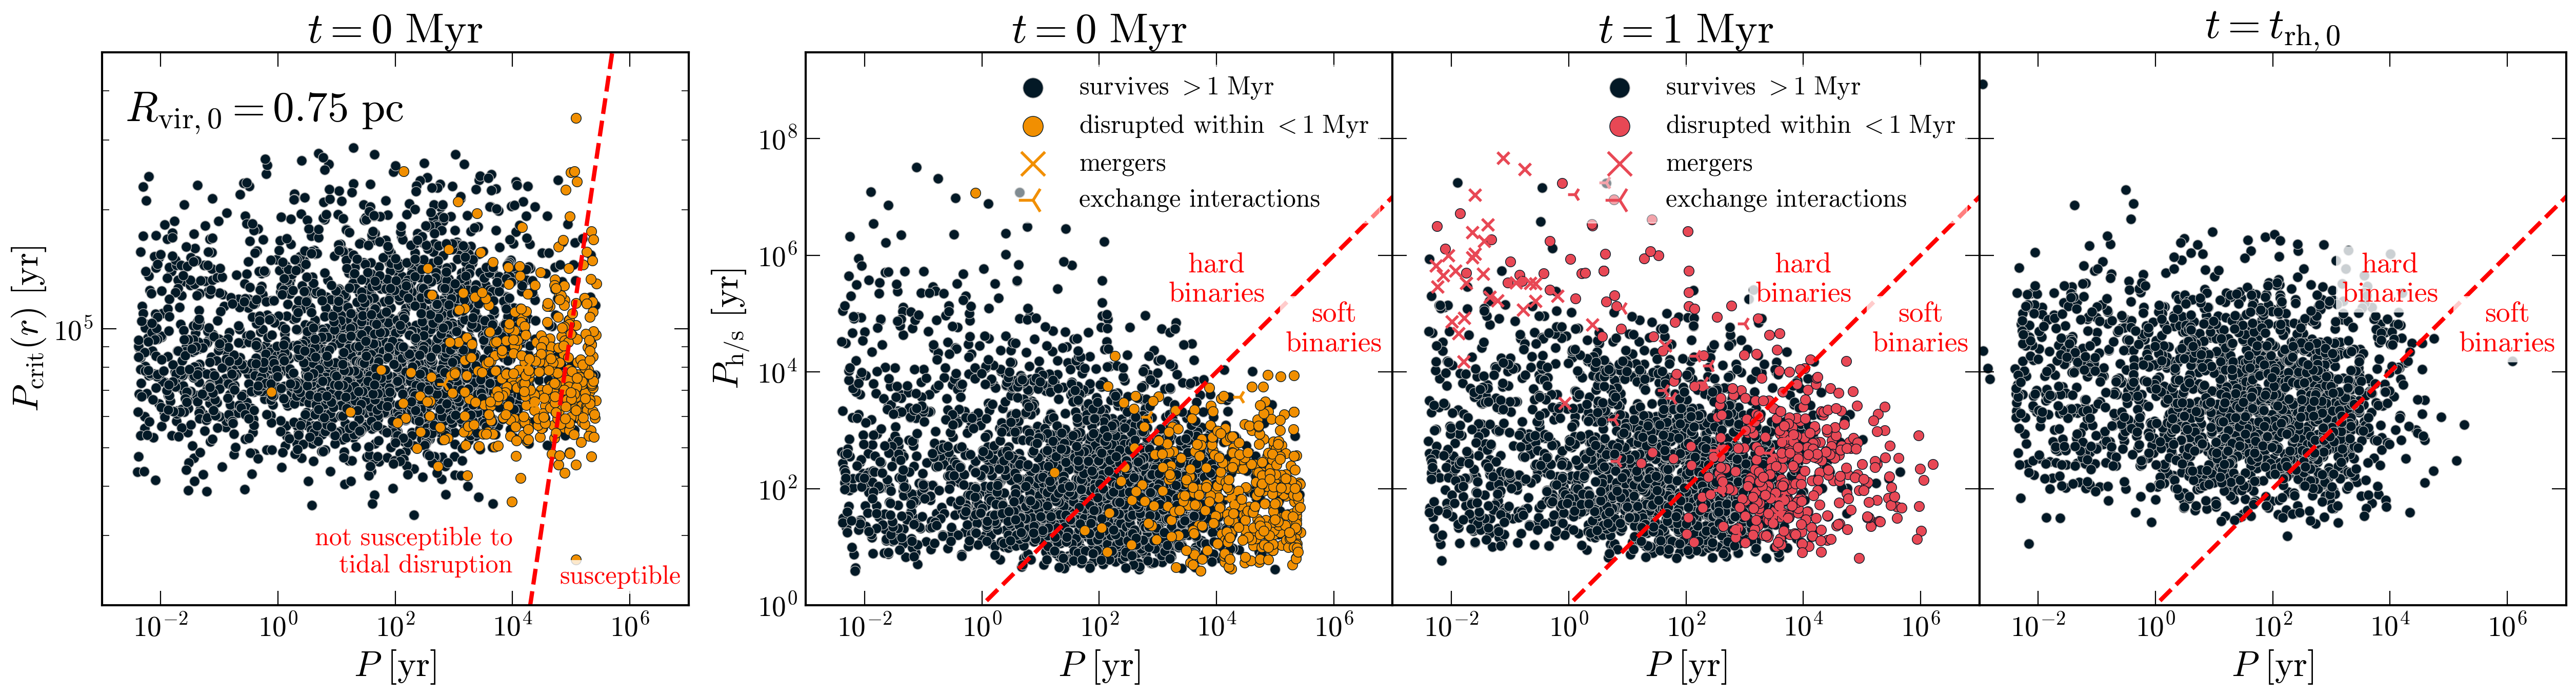

In [8]:
make_ibe_plot(n=8, ylim0=[2e4,5e5],t_divide="1myr",
               include_both_panel1_annotations=True, save=True)

finding disruption times starting from t=0


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


tracing binary outcomes


100%|██████████| 2679/2679 [00:42<00:00, 63.46it/s] 


final count of stars that disappeared:  395
making panel 1
MAKING PANEL 2
finding disruption times starting from t=t_cutoff


100%|██████████| 69/69 [00:47<00:00,  1.44it/s]


tracing binary outcomes


100%|██████████| 2386/2386 [01:22<00:00, 29.09it/s] 


final count of stars that disappeared:  429
making 3rd panel
makign fourth panel


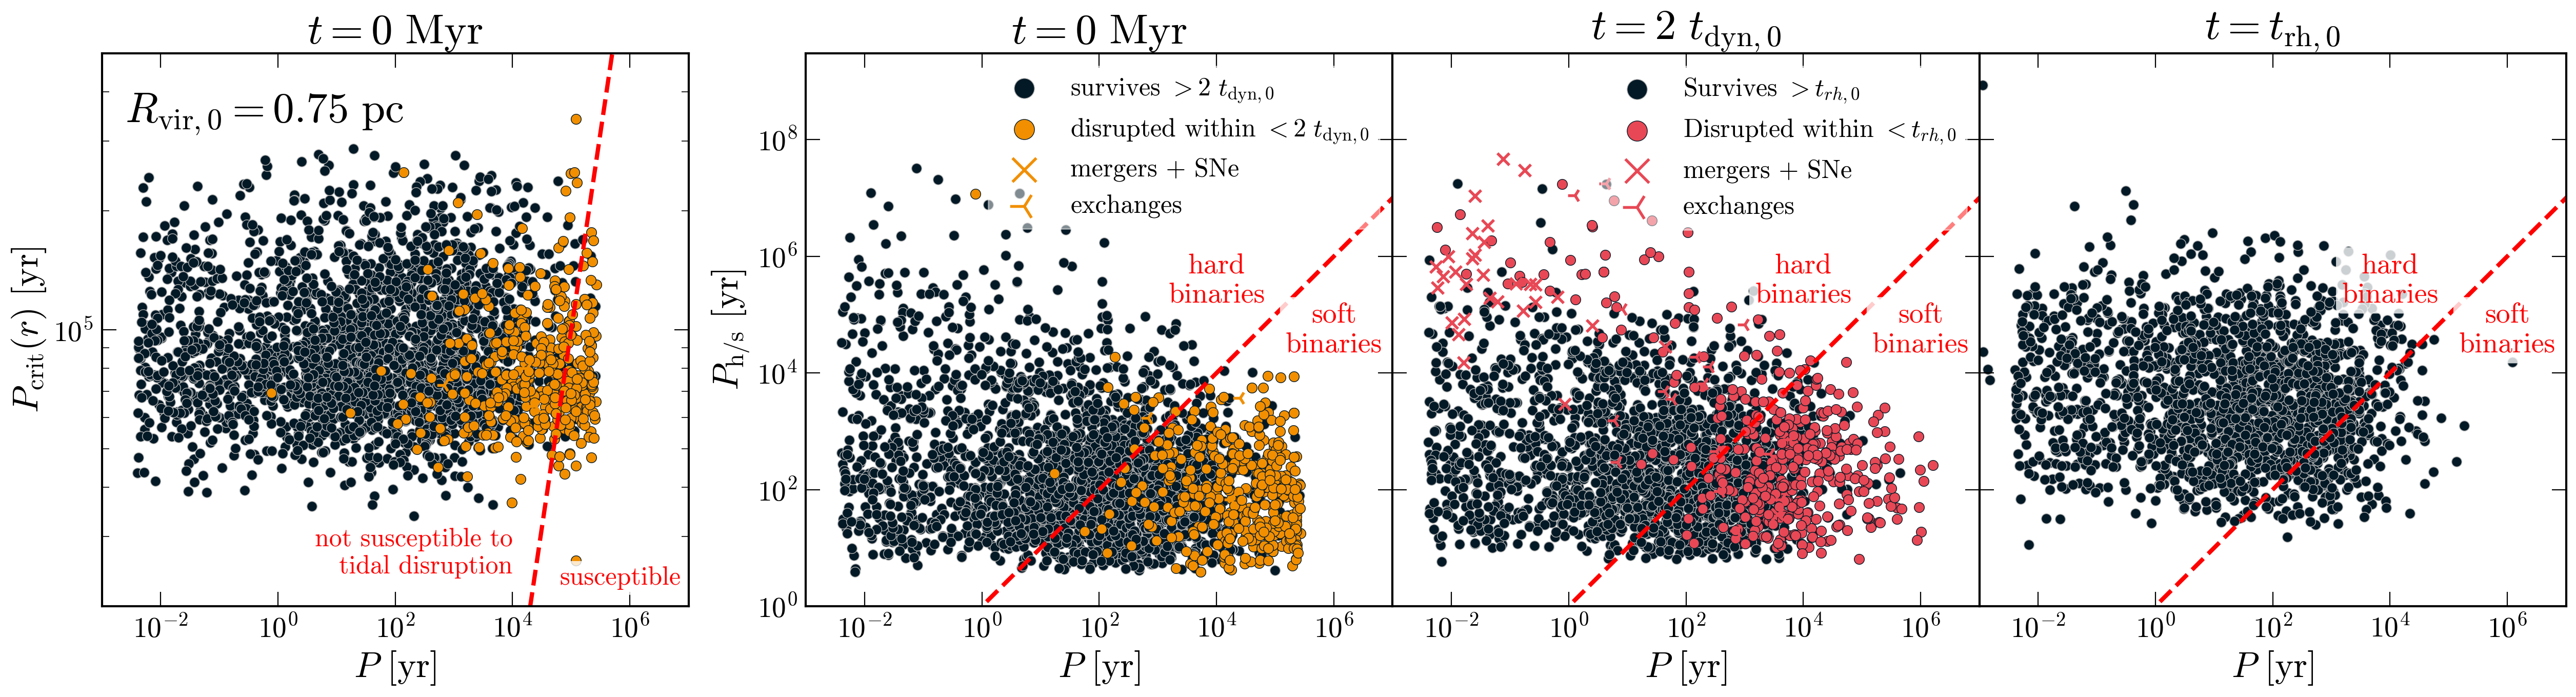

In [8]:
make_ibe_plot(n=8, ylim0=[2e4,5e5],t_divide="2tdyn0",
               include_both_panel1_annotations=True, save=True)

finding disruption times starting from t=0


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


tracing binary outcomes


100%|██████████| 2666/2666 [00:00<00:00, 4686.28it/s]


final count of stars that disappeared:  6
making panel 1
MAKING PANEL 2
finding disruption times starting from t=t_cutoff


100%|██████████| 1276/1276 [14:38<00:00,  1.45it/s]


tracing binary outcomes


100%|██████████| 2663/2663 [00:52<00:00, 51.02it/s] 


final count of stars that disappeared:  355
making 3rd panel
makign fourth panel


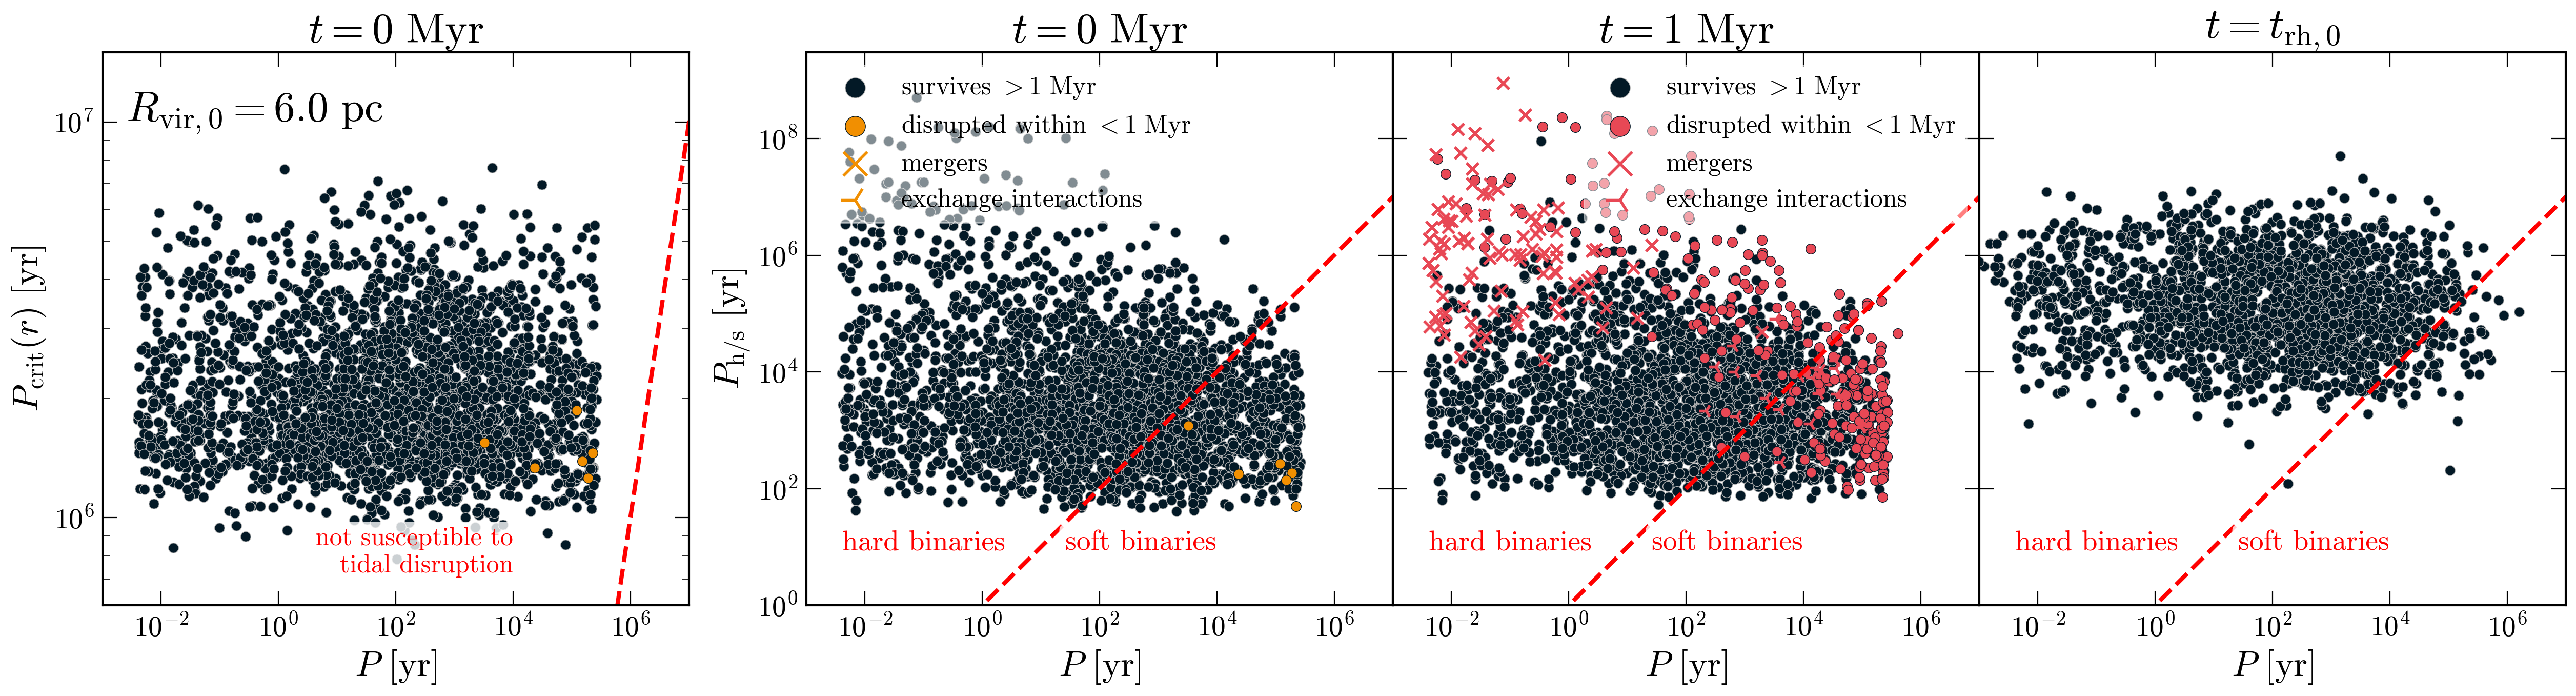

In [14]:
make_ibe_plot(n=14, ylim0=[6e5,(1.5*10**7)],
              include_both_panel1_annotations=False, save=True)

finding disruption times starting from t=0


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


tracing binary outcomes


100%|██████████| 2666/2666 [00:11<00:00, 234.00it/s]


final count of stars that disappeared:  58
making panel 1
MAKING PANEL 2
finding disruption times starting from t=t_cutoff


100%|██████████| 1261/1261 [16:35<00:00,  1.27it/s]


tracing binary outcomes


100%|██████████| 2613/2613 [01:27<00:00, 30.02it/s]


final count of stars that disappeared:  305
making 3rd panel


/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


makign fourth panel


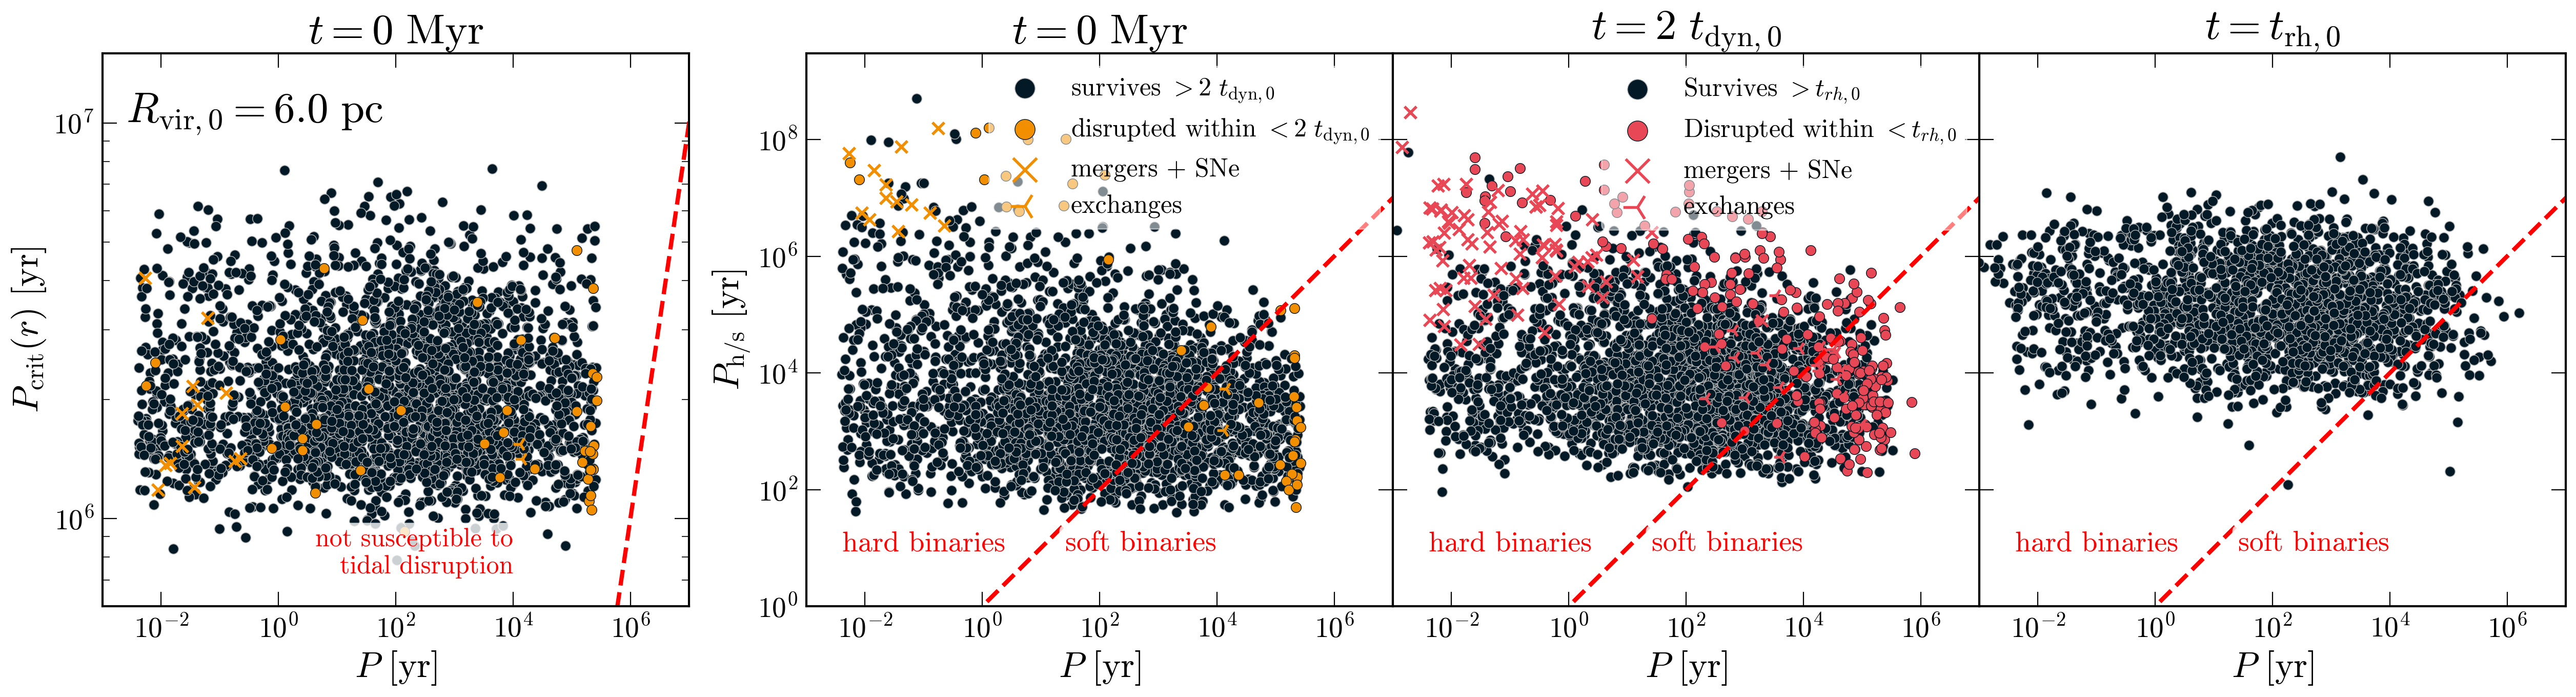

In [9]:
make_ibe_plot(n=14, ylim0=[6e5,(1.5*10**7)], t_divide="2tdyn0",
              include_both_panel1_annotations=False, save=True)